**LABORATORIO 5**

* Dataset:https://drive.google.com/drive/folders/14MZNuZg5xmbKtR3L9Wq_Tdwu9eyNliL6?usp=sharing
* repositorio github:https://github.com/R1mber/sis421/tree/master/Laboratorios
* DenseNet creada 2016 ultima actualizacion 2018
densenet121

torchvision.models.densenet121(pretrained: bool = False, progress: bool = True, **kwargs: Any) → torchvision.models.densenet.DenseNet

Densenet-121 model from “Densely Connected Convolutional Networks”. The required minimum input size of the model is 29x29.

***Parametross***
* pretrained (bool) – If True, returns a model pre-trained on ImageNet
* progress (bool) – If True, displays a progress bar of the download to stderr
* memory_efficient (bool) – but slower. Default: False. See “paper”

In [42]:
import os
import torch
import random
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from PIL import Image
from skimage import io

In [43]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [45]:
#cp -av /content/drive/MyDrive/inteligencia_artificial/ia2/dataset_flores /content/img

In [46]:
path = '/content/img/'
directorios = os.listdir(path)
directorios

['tagetes', 'claveles', 'rosas', 'Hibisco', 'lirio', 'Girasoles', 'FlorRita']

In [47]:
labels_def = {'Hibisco':0, 'Girasoles':1, 'tagetes':2, 'FlorRita':3, 'claveles':4,'lirio':5, 'rosas':6}

In [48]:
def loadImages(path, directorio):
    labels_ = []
    images_ = []
    for d in directorio:
        imagenes = os.listdir(path + d)
        for i in imagenes:
            imgPath2 = path + d + '/' + i
            images_.append(imgPath2)
            labels_.append(labels_def[d])
    return images_, labels_

def getText(label):
    for key in labels_def:
      if labels_def[key] == label:
        return key

In [49]:
imgs , labels = loadImages(path,directorios)

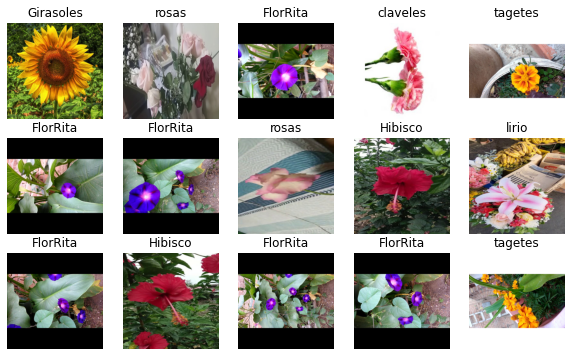

In [50]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(getText(labels[ix]))
plt.show()

In [51]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.05, stratify=labels)

len(train_imgs), len(test_imgs)

(7385, 389)

In [52]:
class Dataset(torch.utils.data.Dataset):
    # constructor
    def __init__(self, X, Y):
        self.X = X #torch.from_numpy(X).float().cuda()
        self.Y = Y #torch.from_numpy(Y).long().cuda()
    # devolvemos el número de datos en el dataset
    def __len__(self):
        return len(self.X)
    # devolvemos el elemento `ix` del dataset
    def __getitem__(self, ix):
        img1 = Image.open(self.X[ix])
        new_img = img1.resize((60,60))
        #normalizamos la imagen 
        npImage = np.array(new_img)
        #return self.X[ix], self.Y[ix]
        #img = self.trans(image=img)["image"]
        return torch.from_numpy(npImage / 255.).float().permute(2,0,1), torch.tensor(self.Y[ix])

In [53]:
dataset = {
    'train': Dataset(train_imgs, train_labels), 
    'test': Dataset(test_imgs, test_labels)
}
len(dataset['train']), len(dataset['test']),

(7385, 389)

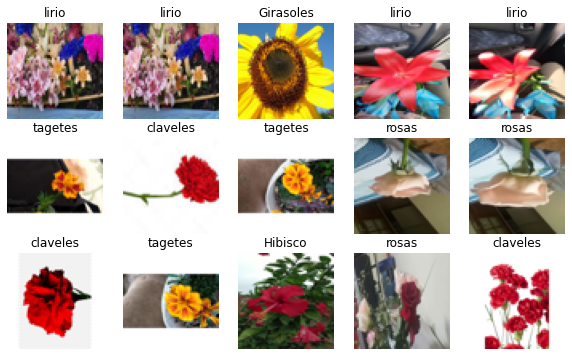

In [54]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['test'])-1)
    img, lab = dataset['test'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(getText(lab))
    #ax.set_title(classes[lab])
plt.show()

In [55]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=65, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=50, shuffle=False)
}

x_train, y_train = next(iter(dataloader['train']))

In [56]:
x_train.shape ,x_train[0].shape

(torch.Size([65, 3, 60, 60]), torch.Size([3, 60, 60]))

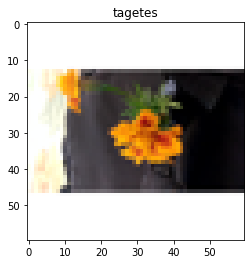

In [57]:
rand = random.randint(0, len(x_train))
img_perm=x_train[rand].permute(1, 2,0)
plt.imshow(img_perm)
plt.title(getText(y_train[rand]))
plt.show()

In [64]:
densenet = torchvision.models.densenet201()
densenet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [58]:
class Model(torch.nn.Module):
  def __init__(self, n_outputs=7, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    densenet = torchvision.models.densenet201(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.densenet = torch.nn.Sequential(*list(densenet.children())[:-1])
    #print(self.densenet)
    if freeze:
      for param in self.densenet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(1920, 7)
    print(self.fc)
  def forward(self, x):
    x = self.densenet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    
    return x

  def unfreeze(self):
    for param in self.densenet.parameters():
        param.requires_grad=True

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [59]:
#torch.cuda.empty_cache()
model = Model()
outputs = model(torch.randn(64, 3, 60, 60))
outputs.shape

Linear(in_features=1920, out_features=7, bias=True)


torch.Size([64, 7])

In [60]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

**Entrenando desde cero**

In [61]:
model = Model()
fit(model, dataloader, epochs=6)

Linear(in_features=1920, out_features=7, bias=True)


val_loss 0.10452 val_acc 0.96929: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 1/15 loss 0.27336 val_loss 0.10452 acc 0.92901 val_acc 0.96929


val_loss 0.05864 val_acc 0.98609: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 2/15 loss 0.05050 val_loss 0.05864 acc 0.98934 val_acc 0.98609


val_loss 0.04395 val_acc 0.98679: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 3/15 loss 0.02274 val_loss 0.04395 acc 0.99609 val_acc 0.98679


val_loss 0.03003 val_acc 0.98929: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 4/15 loss 0.01288 val_loss 0.03003 acc 0.99843 val_acc 0.98929


val_loss 0.02927 val_acc 0.99429: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 5/15 loss 0.00772 val_loss 0.02927 acc 0.99973 val_acc 0.99429


val_loss 0.03107 val_acc 0.98929: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 6/15 loss 0.00562 val_loss 0.03107 acc 0.99960 val_acc 0.98929


val_loss 0.02960 val_acc 0.98929: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 7/15 loss 0.00515 val_loss 0.02960 acc 0.99987 val_acc 0.98929


val_loss 0.04025 val_acc 0.99250: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 8/15 loss 0.00396 val_loss 0.04025 acc 0.99956 val_acc 0.99250


val_loss 0.02256 val_acc 0.99750: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 9/15 loss 0.00367 val_loss 0.02256 acc 0.99973 val_acc 0.99750


val_loss 0.02721 val_acc 0.99750: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 10/15 loss 0.00256 val_loss 0.02721 acc 1.00000 val_acc 0.99750


val_loss 0.03083 val_acc 0.99179: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 11/15 loss 0.00228 val_loss 0.03083 acc 0.99987 val_acc 0.99179


val_loss 0.02899 val_acc 0.99500: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 12/15 loss 0.00320 val_loss 0.02899 acc 0.99946 val_acc 0.99500


val_loss 0.02853 val_acc 0.99500: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 13/15 loss 0.00187 val_loss 0.02853 acc 1.00000 val_acc 0.99500


val_loss 0.03268 val_acc 0.99250: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 14/15 loss 0.00190 val_loss 0.03268 acc 0.99987 val_acc 0.99250


val_loss 0.02957 val_acc 0.99500: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

Epoch 15/15 loss 0.00162 val_loss 0.02957 acc 1.00000 val_acc 0.99500


__Transfer Learning__




In [65]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

Linear(in_features=1920, out_features=7, bias=True)


val_loss 0.50754 val_acc 0.92218: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 1/5 loss 0.96516 val_loss 0.50754 acc 0.80169 val_acc 0.92218


val_loss 0.32147 val_acc 0.94538: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 2/5 loss 0.43214 val_loss 0.32147 acc 0.93330 val_acc 0.94538


val_loss 0.24930 val_acc 0.95788: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 3/5 loss 0.31546 val_loss 0.24930 acc 0.94877 val_acc 0.95788


val_loss 0.20801 val_acc 0.96538: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 4/5 loss 0.25377 val_loss 0.20801 acc 0.95633 val_acc 0.96538


val_loss 0.17766 val_acc 0.96788: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

Epoch 5/5 loss 0.21774 val_loss 0.17766 acc 0.96294 val_acc 0.96788


**fine tunning**

In [66]:
model = Model(pretrained=True, freeze=False)
fit(model, dataloader)

Linear(in_features=1920, out_features=7, bias=True)


val_loss 0.03924 val_acc 0.98929: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 1/5 loss 0.30495 val_loss 0.03924 acc 0.93549 val_acc 0.98929


val_loss 0.02620 val_acc 0.99000: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 2/5 loss 0.02929 val_loss 0.02620 acc 0.99546 val_acc 0.99000


val_loss 0.01584 val_acc 0.99500: 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 3/5 loss 0.01188 val_loss 0.01584 acc 0.99892 val_acc 0.99500


val_loss 0.02071 val_acc 0.99000: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 4/5 loss 0.00758 val_loss 0.02071 acc 0.99946 val_acc 0.99000


val_loss 0.00926 val_acc 0.99500: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]

Epoch 5/5 loss 0.00758 val_loss 0.00926 acc 0.99892 val_acc 0.99500


In [67]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)
model.unfreeze()
fit(model, dataloader, lr=1e-4)

Linear(in_features=1920, out_features=7, bias=True)


val_loss 0.50674 val_acc 0.93359: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 1/5 loss 0.97064 val_loss 0.50674 acc 0.79322 val_acc 0.93359


val_loss 0.32040 val_acc 0.95609: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 2/5 loss 0.43562 val_loss 0.32040 acc 0.93165 val_acc 0.95609


val_loss 0.24587 val_acc 0.96109: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 3/5 loss 0.31347 val_loss 0.24587 acc 0.94836 val_acc 0.96109


val_loss 0.20119 val_acc 0.97429: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 4/5 loss 0.25312 val_loss 0.20119 acc 0.95592 val_acc 0.97429


val_loss 0.18646 val_acc 0.96929: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 5/5 loss 0.21804 val_loss 0.18646 acc 0.96233 val_acc 0.96929


val_loss 0.16287 val_acc 0.97679: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 1/5 loss 0.19433 val_loss 0.16287 acc 0.96479 val_acc 0.97679


val_loss 0.14437 val_acc 0.97929: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 2/5 loss 0.17642 val_loss 0.14437 acc 0.96866 val_acc 0.97929


val_loss 0.14105 val_acc 0.97929: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 3/5 loss 0.15446 val_loss 0.14105 acc 0.97427 val_acc 0.97929


val_loss 0.12311 val_acc 0.97929: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 4/5 loss 0.14543 val_loss 0.12311 acc 0.97841 val_acc 0.97929


val_loss 0.12042 val_acc 0.98179: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

Epoch 5/5 loss 0.13491 val_loss 0.12042 acc 0.97815 val_acc 0.98179
